### Duplication Check | Pattern Recognition | Image Hashing

#### We start with extraction of images from emails of new claims

In [1]:
# IMAGES FROM PDF IMAGES
import os
import extract_msg
import fitz  # PyMuPDF
from pdf2image import convert_from_path
from tqdm import tqdm

# Directory containing the saved emails
email_directory = r"C:\PRA Image Project\Emails"
# email_directory = r"C:\Users\arpitag\Downloads\Interio\Smartnet PRA mails"
# Directory to save the images
image_directory = r"C:\PRA Image Project\New"
# image_directory = r"C:\Users\arpitag\Downloads\Interio\Pics"

if not os.path.exists(image_directory):
    os.makedirs(image_directory)

poppler_path = r"C:\Users\arpitag\AppData\Local\Programs\poppler-23.11.0\Library\bin" 

def is_image_file(filename):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
    return any(filename.lower().endswith(ext) for ext in image_extensions)

def extract_images_from_pdf(pdf_path, output_folder, base_filename):
    try:
        doc = fitz.open(pdf_path)
        if doc.is_encrypted:
            try:
                doc.authenticate('')  # Attempt to decrypt with an empty password
            except Exception as e:
                return

        for page_num in range(len(doc)):
            for img_index, img in enumerate(doc.get_page_images(page_num)):
                xref = img[0]
                pix = fitz.Pixmap(doc, xref)
                if pix.n - pix.alpha < 4:  # this is GRAY or RGB
                    pix.save(os.path.join(output_folder, f"{base_filename}_page{page_num + 1}_img{img_index}.png"))
                else:  # CMYK: convert to RGB first
                    fitz.Pixmap(fitz.csRGB, pix).save(os.path.join(output_folder, f"{base_filename}_page{page_num + 1}_img{img_index}.png"))
                pix = None
    except Exception as e:
        return

# Process each email file
for filename in tqdm(os.listdir(email_directory)):
    if filename.endswith('.msg'):
        file_path = os.path.join(email_directory, filename)
        with extract_msg.Message(file_path) as msg:
            for attachment in msg.attachments:
                if is_image_file(attachment.longFilename or attachment.shortFilename):
                    image_name = attachment.longFilename or attachment.shortFilename
                    if image_name:
                        file_path = os.path.join(image_directory, image_name)
                        with open(file_path, 'wb') as f:
                            f.write(attachment.data)
                elif attachment.longFilename and attachment.longFilename.lower().endswith('.pdf'):
                    # Temporarily save the PDF file
                    temp_pdf_path = os.path.join(image_directory, attachment.longFilename)
                    with open(temp_pdf_path, 'wb') as f:
                        f.write(attachment.data)
                    # Extract images from the PDF
                    extract_images_from_pdf(temp_pdf_path, image_directory, os.path.splitext(attachment.longFilename)[0])
                    #os.remove(temp_pdf_path)  # Clean up the temporary PDF file

100%|██████████| 561/561 [02:21<00:00,  3.96it/s]


#### Now we check hash of each new image with hashes of all images of claims made in past one year. We compted the hashes of these past images separately and stored them in a text file

In [ ]:
import os
from PIL import Image, UnidentifiedImageError
import imagehash
import shutil
from tqdm import tqdm

# File to store hashes
hashes_file = r"C:\PRA Image Project\Hashes\hash\hashes.txt"
pdhashes_file = r"C:\PRA Image Project\Hashes\pdhash\pdhashes.txt"

def save_hash_to_file(hash_file, img_hash, filename):
    with open(hash_file, 'a') as file:
        file.write(f"{img_hash},{filename}\n")

def load_hashes_from_file(hash_file):
    loaded_hashes = {}
    if os.path.exists(hash_file):
        with open(hash_file, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                if len(parts) == 2:
                    loaded_hashes[imagehash.hex_to_hash(parts[0])] = parts[1]
    return loaded_hashes

# Load previously computed hashes
hashes = load_hashes_from_file(hashes_file)
pdhashes = load_hashes_from_file(pdhashes_file)

# Create sets of already processed filenames
processed_filenames = set(hashes.values())
processed_pd_filenames = set(pdhashes.values())

# We use spreadd sheet style naming to name duplicate images so that they appear next to each other in the output folder
def generate_labels(index):
    # ASCII value for 'A'
    ascii_start = 65
    # Determine the number of letters in the label (A, B, ..., Z, AA, AB, ...)
    num_letters = (index // 52) + 1
    # Calculate label (A, B, C, ..., AA, AB, ...)
    label = ''
    for i in range(num_letters):
        label += chr(ascii_start + ((index // 2) % 26))
    # Calculate number (1 or 2)
    number = 1 if index % 2 == 0 else 2
    return f'{label}{number}'

# Directories
new_image_directory =  r"C:\PRA Image Project\New"
# new_image_directory = "C:\PRA Image Project\Z2_Meta Data Check"
# processed_image_directory =  r"C:\Users\arpitag\OneDrive - Godrej & Boyce Mfg. Co. Ltd\Desktop\Work\23-24\PRA Sticker Match\pics from pdfs"
processed_image_directory =  r"C:\PRA Image Project\Processed"
duplicates_directory =  r"C:\PRA Image Project\Duplicate"
# duplicates_directory =  r"C:\Users\arpitag\OneDrive - Godrej & Boyce Mfg. Co. Ltd\Desktop\Work\23-24\PRA Sticker Match\Duplicates"
processed_duplicates_directory =  r"C:\PRA Image Project\Processed Duplicates"

# Ensure directories exist
os.makedirs(duplicates_directory, exist_ok=True)
os.makedirs(processed_image_directory, exist_ok=True)

# Function to get image hash
def get_image_hash(image_path):
    try:
        with Image.open(image_path) as img:
            return imagehash.average_hash(img)
    except (UnidentifiedImageError, OSError):
        print(f"Cannot identify image file '{image_path}'. Skipping...")
        return None

similarity_threshold = 0
index = 0


# Now check each image in the New folder
for filename in tqdm(os.listdir(new_image_directory)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        file_path = os.path.join(new_image_directory, filename)
        img_hash = get_image_hash(file_path)
        
        if img_hash is None:
            continue
        duplicate_found = False

        for stored_hash, stored_filename in hashes.items():
            if img_hash - stored_hash <= similarity_threshold:
                if filename[:10]==stored_filename[:10]:
                    duplicate_found = True
                    break  # Skip processing this file as it's a duplicate with the same name prefix
                
                label1 = generate_labels(index)
                label2 = generate_labels(index + 1)

                original_path = os.path.join(processed_image_directory, stored_filename)
                shutil.copy(original_path, os.path.join(duplicates_directory, f'{label1}_{stored_filename}'))
                shutil.copy(file_path, os.path.join(duplicates_directory, f'{label2}_{filename}'))

                index += 2
                duplicate_found = True
                break
        #Check in Processed Duplicates folder        
        for stored_hash, stored_filename in pdhashes.items():
            if img_hash - stored_hash <= similarity_threshold:
                if filename[:10]==stored_filename[:10]:
                    duplicate_found = True
                    break  # Skip processing this file as it's a duplicate with the same name prefix
                
                label1 = generate_labels(index)
                label2 = generate_labels(index + 1)

                original_path = os.path.join(processed_duplicates_directory, stored_filename)
                shutil.copy(original_path, os.path.join(duplicates_directory, f'{label1}_{stored_filename}'))
                shutil.copy(file_path, os.path.join(duplicates_directory, f'{label2}_{filename}'))

                index += 2
                duplicate_found = True
                break

        # Move the image from New to Processed (regardless of whether it's a duplicate)
        shutil.move(file_path, os.path.join(processed_image_directory, filename))
        if not duplicate_found:
            # Add the hash of this new, unique image to the dictionary
            hashes[img_hash] = filename
            save_hash_to_file(hashes_file, img_hash, filename)
            

#### Next we manually delete the FALSE POSITIVES and take further action on duplicates

Few examples of duplicate images are as below

![WhatsApp Image 2024-04-28 at 20.28.39_f7046697.jpg](<attachment:WhatsApp Image 2024-04-28 at 20.28.39_f7046697.jpg>)
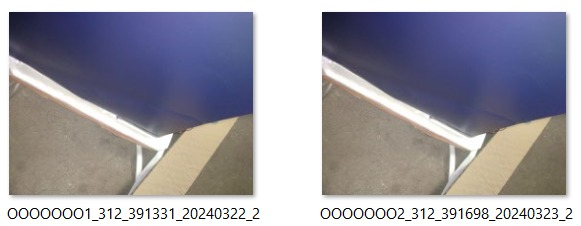

![WhatsApp Image 2024-04-28 at 20.30.00_c4a0c533.jpg](<attachment:WhatsApp Image 2024-04-28 at 20.30.00_c4a0c533.jpg>)
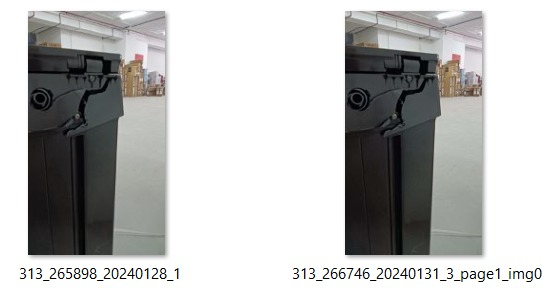

![WhatsApp Image 2024-04-28 at 20.29.26_c4967af9.jpg](<attachment:WhatsApp Image 2024-04-28 at 20.29.26_c4967af9.jpg>)
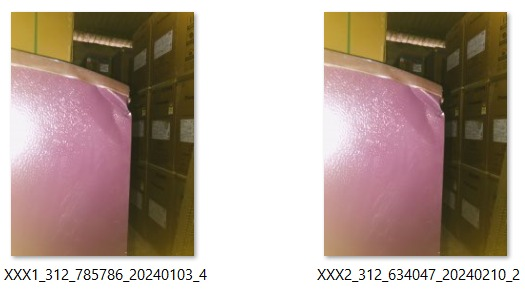

![WhatsApp Image 2024-04-28 at 20.31.43_883f3369.jpg](<attachment:WhatsApp Image 2024-04-28 at 20.31.43_883f3369.jpg>)
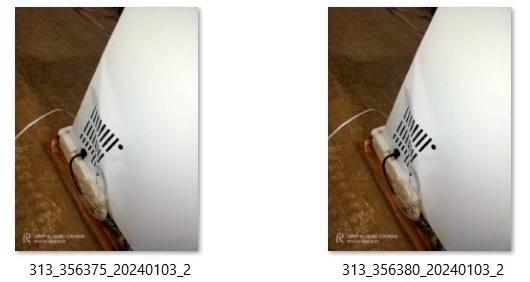

#### We also use the algorithm for Pattern Recognition

Suspected Pattern Image Template is put in "PATTERN TEMPLATE' foolder. All processed images are in 'Processed' folder.
Results are copied to 'Patterns' folder.
We use multiple values of threshold between 2 to 10 to find patterns.

In [ ]:
import os
import shutil
from PIL import Image, UnidentifiedImageError
import imagehash
from tqdm import tqdm

# File to store hashes
hashes_file = r"C:\PRA Image Project\Hashes\hash\hashes.txt"
pdhashes_file = r"C:\PRA Image Project\Hashes\pdhash\pdhashes.txt"

def generate_labels(index):
    # ASCII value for 'A'
    ascii_start = 65
    # Determine the number of letters in the label (A, B, ..., Z, AA, AB, ...)
    num_letters = (index // 52) + 1
    # Calculate label (A, B, C, ..., AA, AB, ...)
    label = ''
    for i in range(num_letters):
        label += chr(ascii_start + ((index // 2) % 26))
    # Calculate number (1 or 2)
    number = 1 if index % 2 == 0 else 2
    return f'{label}{number}'

def save_hash_to_file(hash_file, img_hash, filename):
    with open(hash_file, 'a') as file:
        file.write(f"{img_hash},{filename}\n")

def load_hashes_from_file(hash_file):
    loaded_hashes = {}
    if os.path.exists(hash_file):
        with open(hash_file, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                if len(parts) == 2:
                    loaded_hashes[imagehash.hex_to_hash(parts[0])] = parts[1]
    return loaded_hashes

# Directories
new_image_directory = r"C:\PRA Image Project\PATTERN TEMPLATE"
processed_image_directory = r"C:\PRA Image Project\Processed"
duplicates_directory = r"C:\PRA Image Project\Patterns"

# Ensure directories exist
os.makedirs(duplicates_directory, exist_ok=True)
os.makedirs(processed_image_directory, exist_ok=True)

def get_image_hash(image_path):
    try:
        with Image.open(image_path) as img:
            return imagehash.average_hash(img)
    except UnidentifiedImageError:
        print(f'Warning: Could not identify image file {image_path}. Skipping...')
        return None

similarity_threshold = 10
hashes = load_hashes_from_file(hashes_file)
index = 0


# Now check each image in the New folder
for filename in tqdm(os.listdir(new_image_directory), desc="Checking new images"):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        file_path = os.path.join(new_image_directory, filename)
        img_hash = get_image_hash(file_path)
        if img_hash is None:
            continue  # Skip this file since its hash could not be obtained
        matches = []

        for stored_hash, stored_filename in tqdm(hashes.items()):
            if img_hash - stored_hash <= similarity_threshold:
                matches.append((stored_filename, file_path))

        for match in tqdm(matches):
            stored_filename, file_path = match
            label = generate_labels(index)

            original_path = os.path.join(processed_image_directory, stored_filename)
            shutil.copy(original_path, os.path.join(duplicates_directory, f'{label}_{stored_filename}'))
            index += 1

Few Examples of Pattern found in damage claims

![WhatsApp Image 2024-04-28 at 20.37.10_31093bad.jpg](<attachment:WhatsApp Image 2024-04-28 at 20.37.10_31093bad.jpg>)
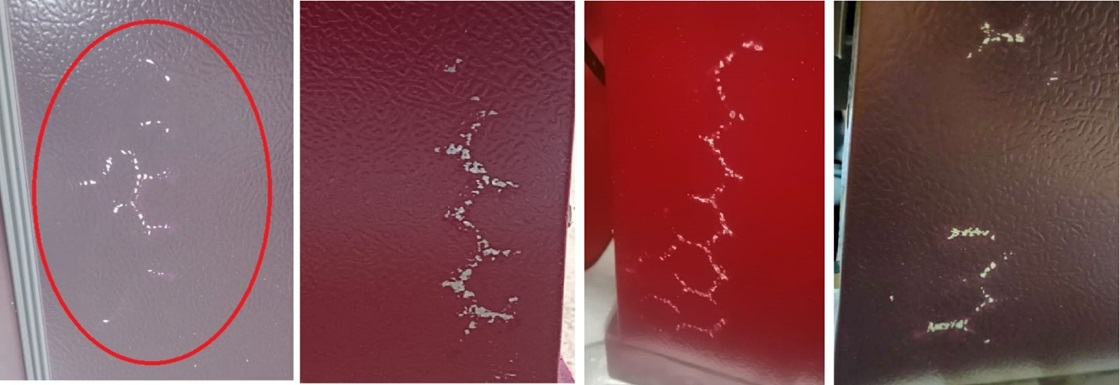

![WhatsApp Image 2024-04-28 at 20.43.09_ba7bc865.jpg](<attachment:WhatsApp Image 2024-04-28 at 20.43.09_ba7bc865.jpg>)
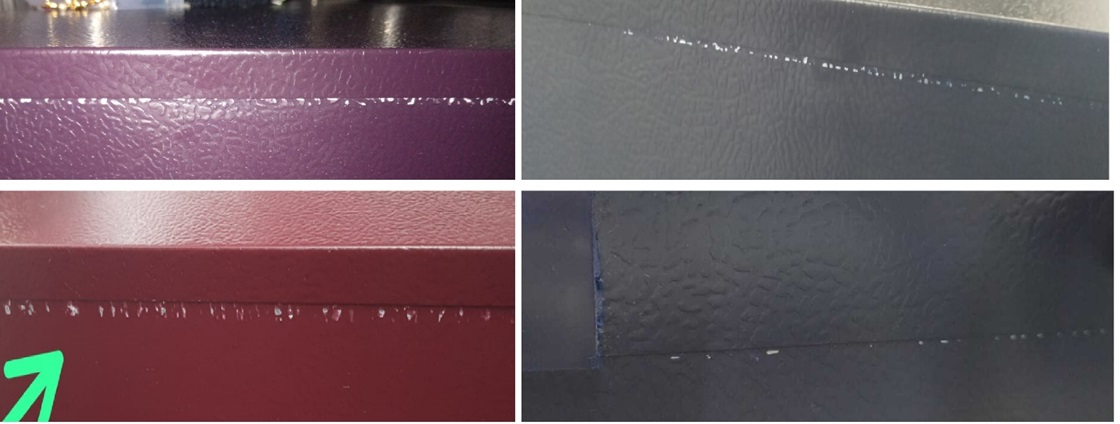

These insights are being regularly shared with Plant Quality and improvements in packaging, processes and design has been initiated to counter such issues.